In [37]:
import pandas as pd
import numpy as np
df = pd.read_csv("../FeatureEgnineering/standard_heartrate.csv")
X = df.drop("Heart Attack Risk", axis = 1)
y = df["Heart Attack Risk"]

In [38]:
X.drop("Unnamed: 0", axis = 1, inplace = True)
X.Sex = (X.Sex == "Male")

## This is for train test split

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Applying SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## This is for GBM model

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline
np.random.seed(123)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 4, 5]
}

# Model and grid search for classification
gbm = GradientBoostingClassifier(random_state=42)
# Initialize the Grid Search model
grid_search = GridSearchCV(gbm,param_grid, cv=5, scoring='accuracy', verbose = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

best_gbm = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100;, score=0.429 total time=   1.9s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100;, score=0.491 total time=   1.9s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100;, score=0.423 total time=   1.8s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100;, score=0.620 total time=   1.7s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100;, score=0.615 total time=   1.7s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.453 total time=   5.6s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.402 total time=   5.5s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.424 total time=   5.4s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.657 total time=   5.1s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, 

In [42]:
best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters for GBM:", best_hyperparameters)

Best Hyperparameters for GBM: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}


## Model Evaluation of GBM

Confusion Matrix:
[[763 362]
 [429 199]]


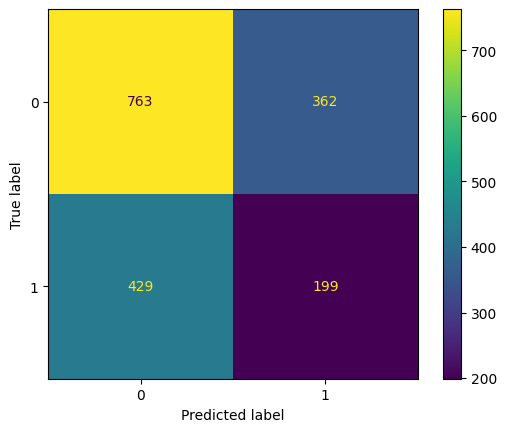

F1 Score: 0.33473507148864595
Accuracy: 0.5487735310895607


In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

# Predict on the testing set
y_pred = best_gbm.predict(X_test)

# Evaluate performance
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

In [45]:
# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66      1125
           1       0.35      0.32      0.33       628

    accuracy                           0.55      1753
   macro avg       0.50      0.50      0.50      1753
weighted avg       0.54      0.55      0.54      1753

Accuracy: 0.5487735310895607


## This is for NN model

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

layer_configs = [
    [64, 32], 
    [32],
    [16]
]
learning_rates = [0.1, 0.01, 0.001]

# Prepare cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to create a model given a layer configuration
def create_model(layers):
    model = Sequential()
    model.add(Dense(layers[0], activation='relu', input_shape=(X_train_resampled.shape[1],)))
    for nodes in layers[1:]:
        model.add(Dense(nodes, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    return model

# Iterate over configurations and cross-validate
best_score = 0
best_config = None

for layers in layer_configs:
    for lr in learning_rates:
        scores = []
        for train_index, val_index in kf.split(X_train_resampled):
            X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
            y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
            
            # Convert to tensors
            X_train_fold = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
            X_val_fold = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
            y_train_fold = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
            y_val_fold = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
            
            # Create and compile model
            model = create_model(layers)
            model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
            
            # Train model on the oversampled dataset
            model.fit(X_train_fold, y_train_fold, epochs=100, verbose=0, validation_data=(X_val_fold, y_val_fold))
            
            # Evaluate model on the original validation set
            _, score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            scores.append(score)
        
        # Average score for this configuration
        avg_score = np.mean(scores)
        print(f"Layers: {layers}, LR: {lr}, Avg Accuracy: {avg_score}")
        
        if avg_score > best_score:
            best_score = avg_score
            best_config = (layers, lr)

print(f"Best Configuration: Layers: {best_config[0]}, Learning Rate: {best_config[1]}, Accuracy: {best_score}")

Layers: [64, 32], LR: 0.1, Avg Accuracy: 0.4885548114776611
Layers: [64, 32], LR: 0.01, Avg Accuracy: 0.6171372413635254
Layers: [64, 32], LR: 0.001, Avg Accuracy: 0.635699462890625
Layers: [32], LR: 0.1, Avg Accuracy: 0.6253609418869018
Layers: [32], LR: 0.01, Avg Accuracy: 0.6189157009124756
Layers: [32], LR: 0.001, Avg Accuracy: 0.6289196372032165
Layers: [16], LR: 0.1, Avg Accuracy: 0.6263610005378724
Layers: [16], LR: 0.01, Avg Accuracy: 0.6233623623847961
Layers: [16], LR: 0.001, Avg Accuracy: 0.6250266194343567
Best Configuration: Layers: [64, 32], Learning Rate: 0.001, Accuracy: 0.635699462890625


## Model Validation for NN

In [55]:
model = create_model([64, 32])
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, verbose=0)
nn_predictions = model.predict(X_test)
nn_predictions = nn_predictions > 0.5
nn_accuracy = accuracy_score(np.array(y_test), nn_predictions)
print(f"Neural Network Model Accuracy: {nn_accuracy}")

55/55 [==============================] - 0s 402us/step
Neural Network Model Accuracy: 0.5510553337136338


Confusion Matrix:
[[738 387]
 [400 228]]


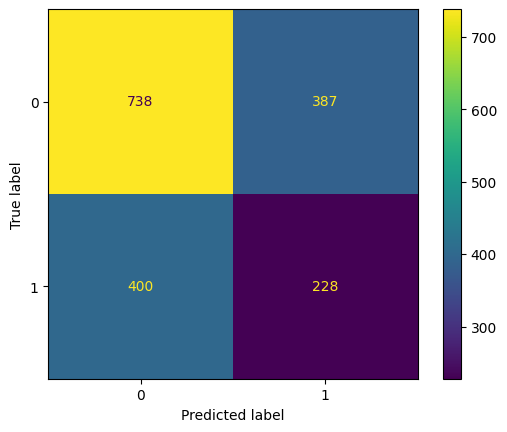

F1 Score: 0.36685438455349956
Accuracy: 0.5510553337136338


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

# Evaluate performance
conf_matrix = confusion_matrix(y_test, nn_predictions)
f1 = f1_score(y_test, nn_predictions)
accuracy = accuracy_score(y_test, nn_predictions)

# Print the evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

In [58]:
# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, nn_predictions))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65      1125
           1       0.37      0.36      0.37       628

    accuracy                           0.55      1753
   macro avg       0.51      0.51      0.51      1753
weighted avg       0.55      0.55      0.55      1753

